In [219]:
import emcee
import matplotlib.pyplot as plt
import numpy as np
from corner import corner


In [217]:
import surp
import vice

from surp.gce_math import Z_to_MH, MH_to_Z

In [7]:
vice.yields.ccsne.settings["c"] = 0


In [208]:
class LinearModel():
    def __init__(self):
        pass
            
    def __call__(self, x, theta):
        m, b, σ = theta
        return m * x + b
    
    def log_prior(self, theta):
        m, b, sigma = theta
        p = 0
        p += np.log(normal(m, 0, 1e-3))
        p += np.log(normal(b, 0, 1e-3))
        p += np.log(log_normal(sigma, 1e-8, 0.5))

        if np.isnan(p):
            return -np.inf
        return p
    
    def p0(self, N):
        return [1e-3, 1e-3, 1e-8]

In [223]:
class LogLinearModel():
    def __init__(self):
        pass
            
    def __call__(self, x, theta):
        z = MH_to_Z(x)
        m, b, σ = theta
        return m * z + b
    
    def log_prior(self, theta):
        m, b, sigma = theta
        p = 0
        p += np.log(normal(m, 0, 1e-2))
        p += np.log(normal(b, 0, 3e-3))
        p += np.log(log_normal(sigma, 1e-8, 0.5))

        if np.isnan(p):
            return -np.inf
        return p
    
    def p0(self, N):
        return [1e-2, 3e-3, 1e-8]

In [224]:
def linear_model(x, theta):
    """Linear model function y = mx + b."""
    m, b, sigma = theta
    return m * x + b

In [225]:
def normal(x, mu, sigma):
    return 1/np.sqrt(2*np.pi * sigma**2) * np.exp(-(x-mu)**2 / (2*sigma**2))

def log_normal(x, mu, sigma):
    return np.where(x >= 0, normal(np.log(x), np.log(mu), sigma), 0)

In [226]:
def log_likelihood(theta, x, y, model):
    pred = model(x, theta)
    sigma2 = theta[-1]
    return -0.5 * np.sum((y - pred) ** 2 / sigma2 + np.log(2 * np.pi * sigma2))

def log_probability(theta, x, y, model):
    p = model.log_prior(theta)
    l = log_likelihood(theta, x, y, model) 
    
    lp = l + p
    return np.where(np.isfinite(lp), lp, -np.inf)

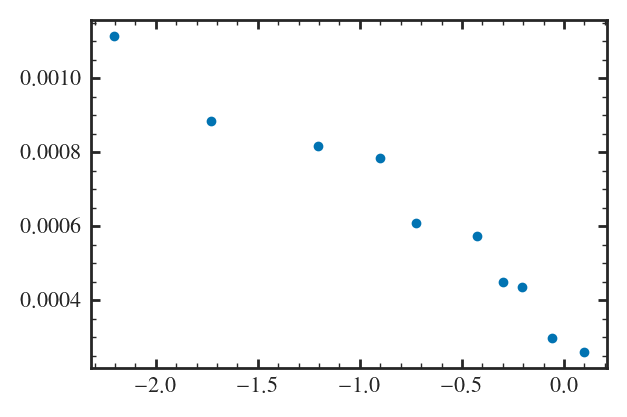

In [227]:
study = "cristallo11"
y1, m1, z1 = vice.yields.agb.grid("c", study=study)
mh1 = Z_to_MH(z1)
vice.yields.agb.settings["c"] = vice.yields.agb.interpolator("c", study=study)
y_c_agb1 = np.array([surp.calc_y(z) for z in z1])

plt.scatter(mh1, y_c_agb1)

  3%|▎         | 29/1000 [00:00<00:03, 285.66it/s]/tmp/slurmtmp.26960816/ipykernel_214441/4271747773.py:5: RuntimeWarning: invalid value encountered in log
  return np.where(x >= 0, normal(np.log(x), np.log(mu), sigma), 0)
/tmp/slurmtmp.26960816/ipykernel_214441/1855935162.py:15: RuntimeWarning: divide by zero encountered in log
  p += np.log(log_normal(sigma, 1e-8, 0.5))
/tmp/slurmtmp.26960816/ipykernel_214441/4247209102.py:4: RuntimeWarning: invalid value encountered in log
  return -0.5 * np.sum((y - pred) ** 2 / sigma2 + np.log(2 * np.pi * sigma2))
100%|██████████| 1000/1000 [00:03<00:00, 298.20it/s]


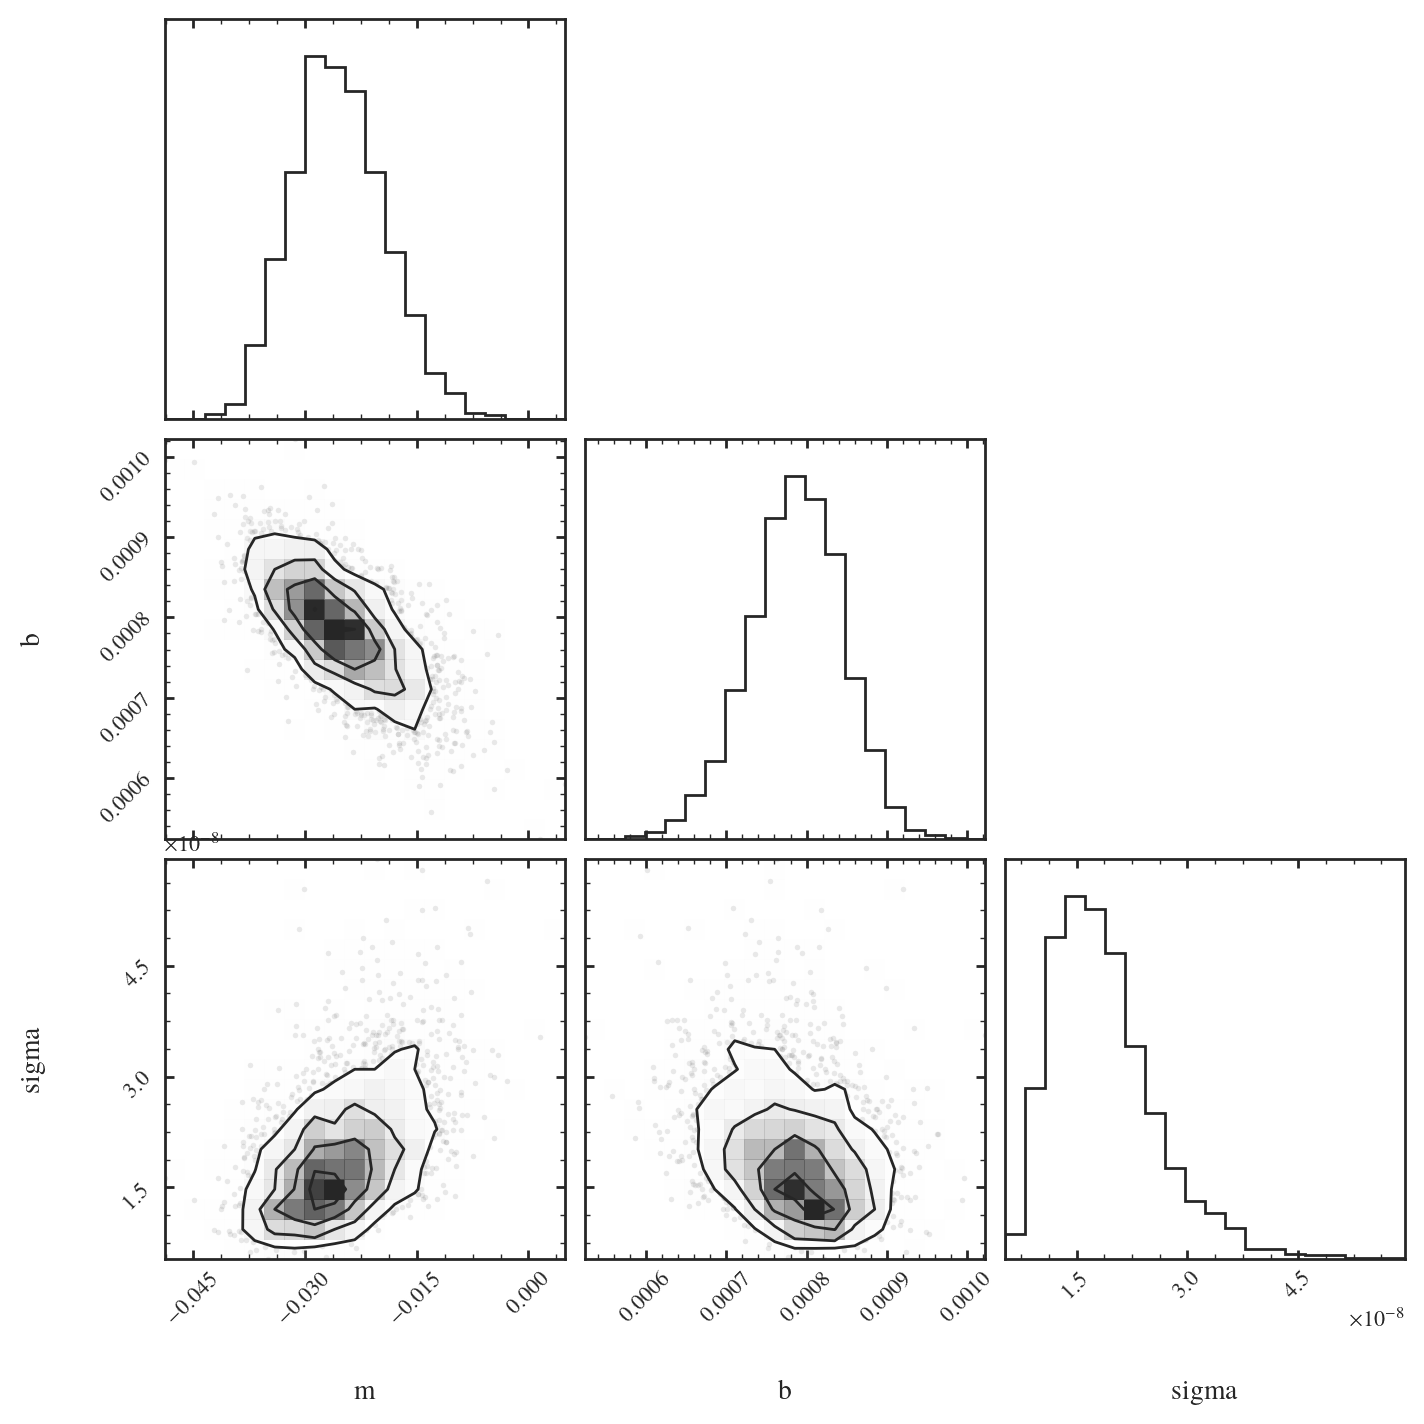

In [228]:

model = LogLinearModel()
p0 = model.p0(1)
ndim, nwalkers = len(p0), 50
p0 = p0 *  (1 + 1e-4 * np.random.randn(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(mh1, y_c_agb1, model))
sampler.run_mcmc(p0, 1000, progress=True);
samples = sampler.get_chain(discard=100, thin=15, flat=True)
corner(samples, labels=["m", "b", "sigma"]);

(-0.0001, 0.004273385286154343)

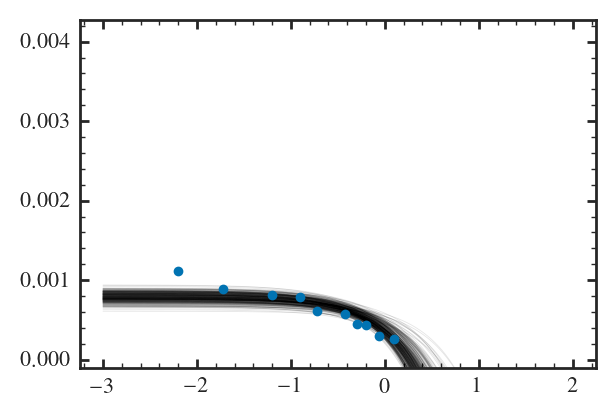

In [230]:

for i in range(0, len(samples), 10):
    theta = samples[i, :]
    x = np.linspace(-3, 2, 1000)
    y = model(x, theta)
    plt.plot(x, y, lw=0.3, color="k", alpha=0.1)
    
plt.scatter(mh1, y_c_agb1, zorder=3)
plt.ylim(-1e-4)

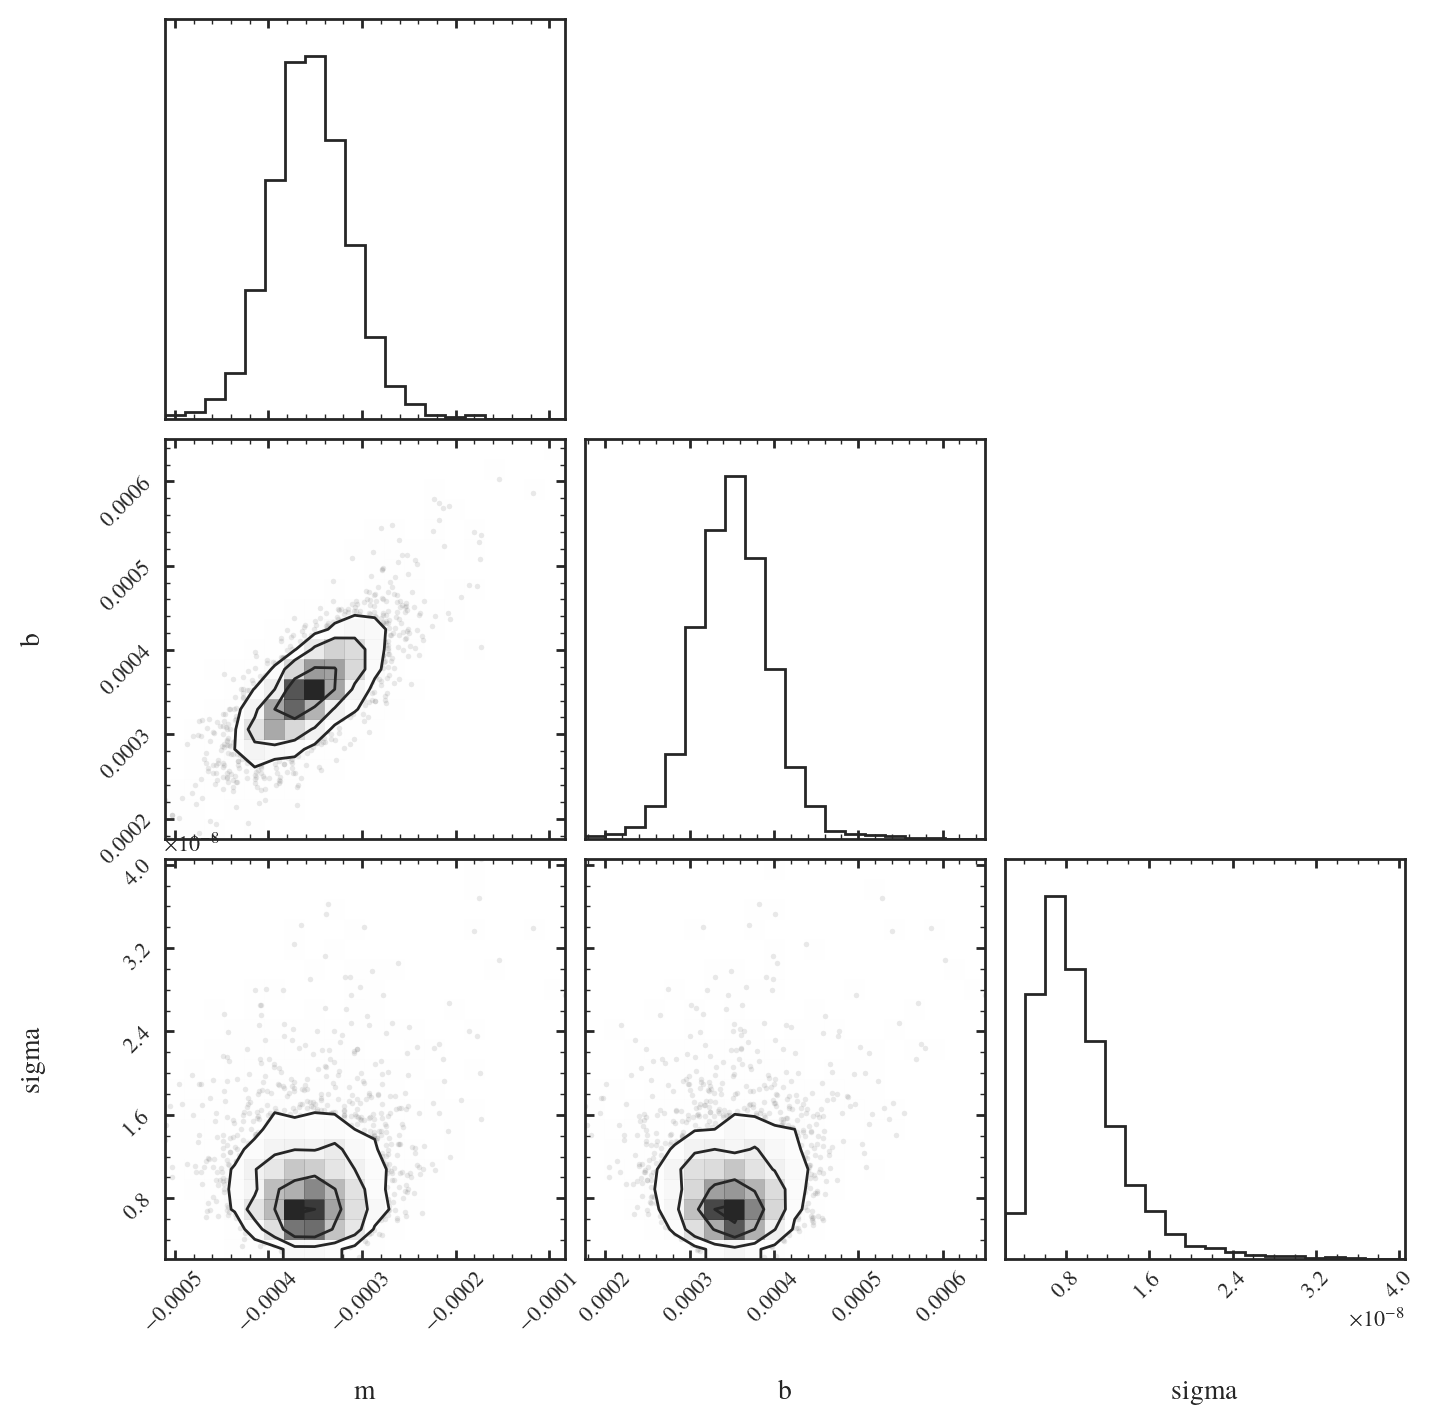

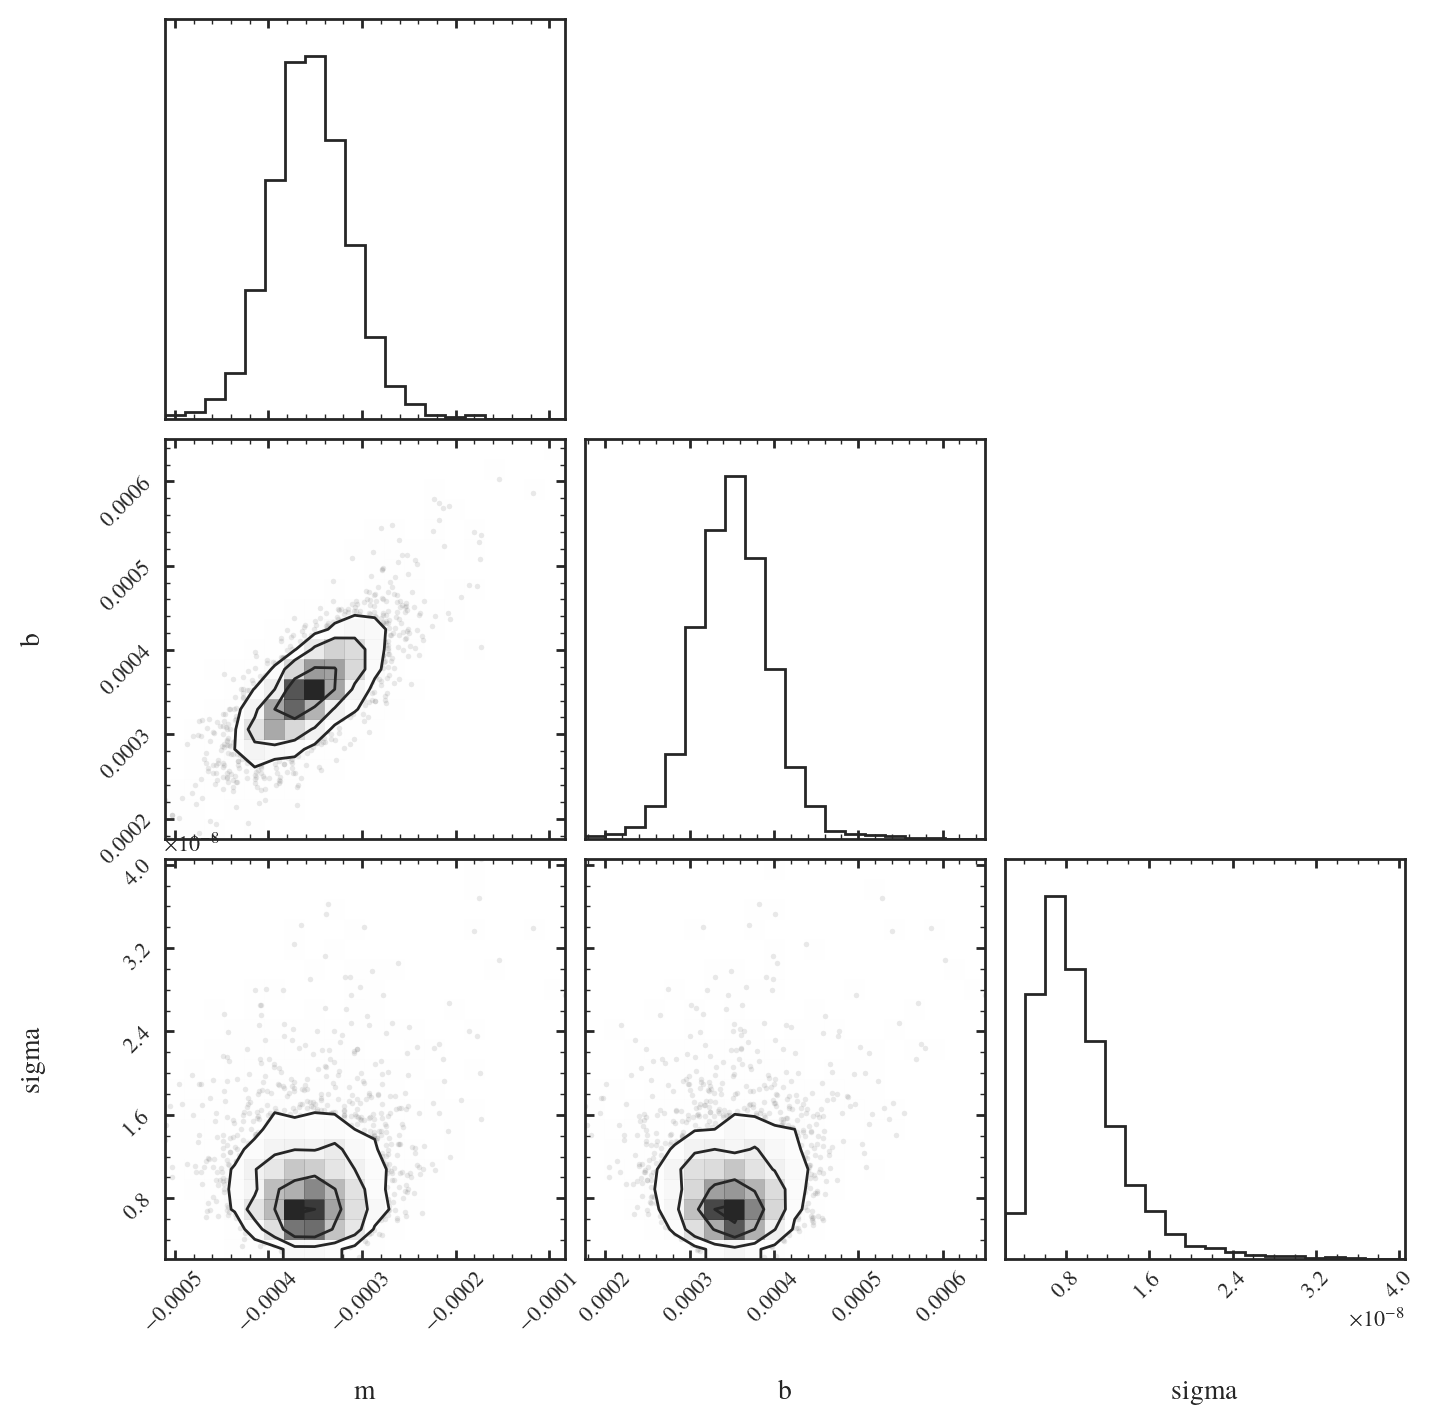

# V13

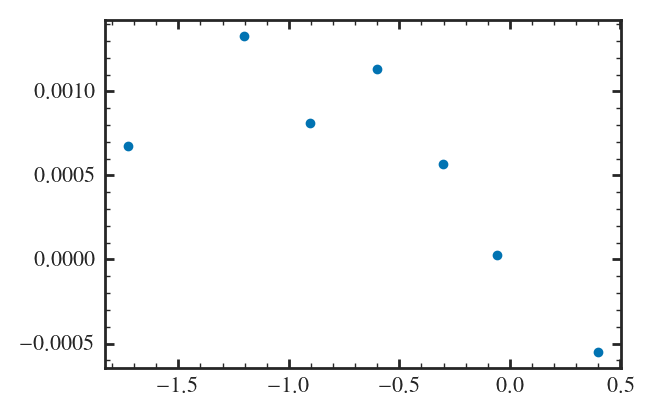

In [242]:
study = "ventura13"
y1, m1, z1 = vice.yields.agb.grid("c", study=study)
mh1 = Z_to_MH(z1)
vice.yields.agb.settings["c"] = vice.yields.agb.interpolator("c", study=study)
y_c_agb1 = np.array([surp.calc_y(z) for z in z1])

plt.scatter(mh1, y_c_agb1)

  2%|▏         | 20/1000 [00:00<00:04, 198.28it/s]/tmp/slurmtmp.26960816/ipykernel_214441/4271747773.py:5: RuntimeWarning: invalid value encountered in log
  return np.where(x >= 0, normal(np.log(x), np.log(mu), sigma), 0)
/tmp/slurmtmp.26960816/ipykernel_214441/1855935162.py:15: RuntimeWarning: divide by zero encountered in log
  p += np.log(log_normal(sigma, 1e-8, 0.5))
/tmp/slurmtmp.26960816/ipykernel_214441/4247209102.py:4: RuntimeWarning: invalid value encountered in log
  return -0.5 * np.sum((y - pred) ** 2 / sigma2 + np.log(2 * np.pi * sigma2))
100%|██████████| 1000/1000 [00:03<00:00, 307.12it/s]


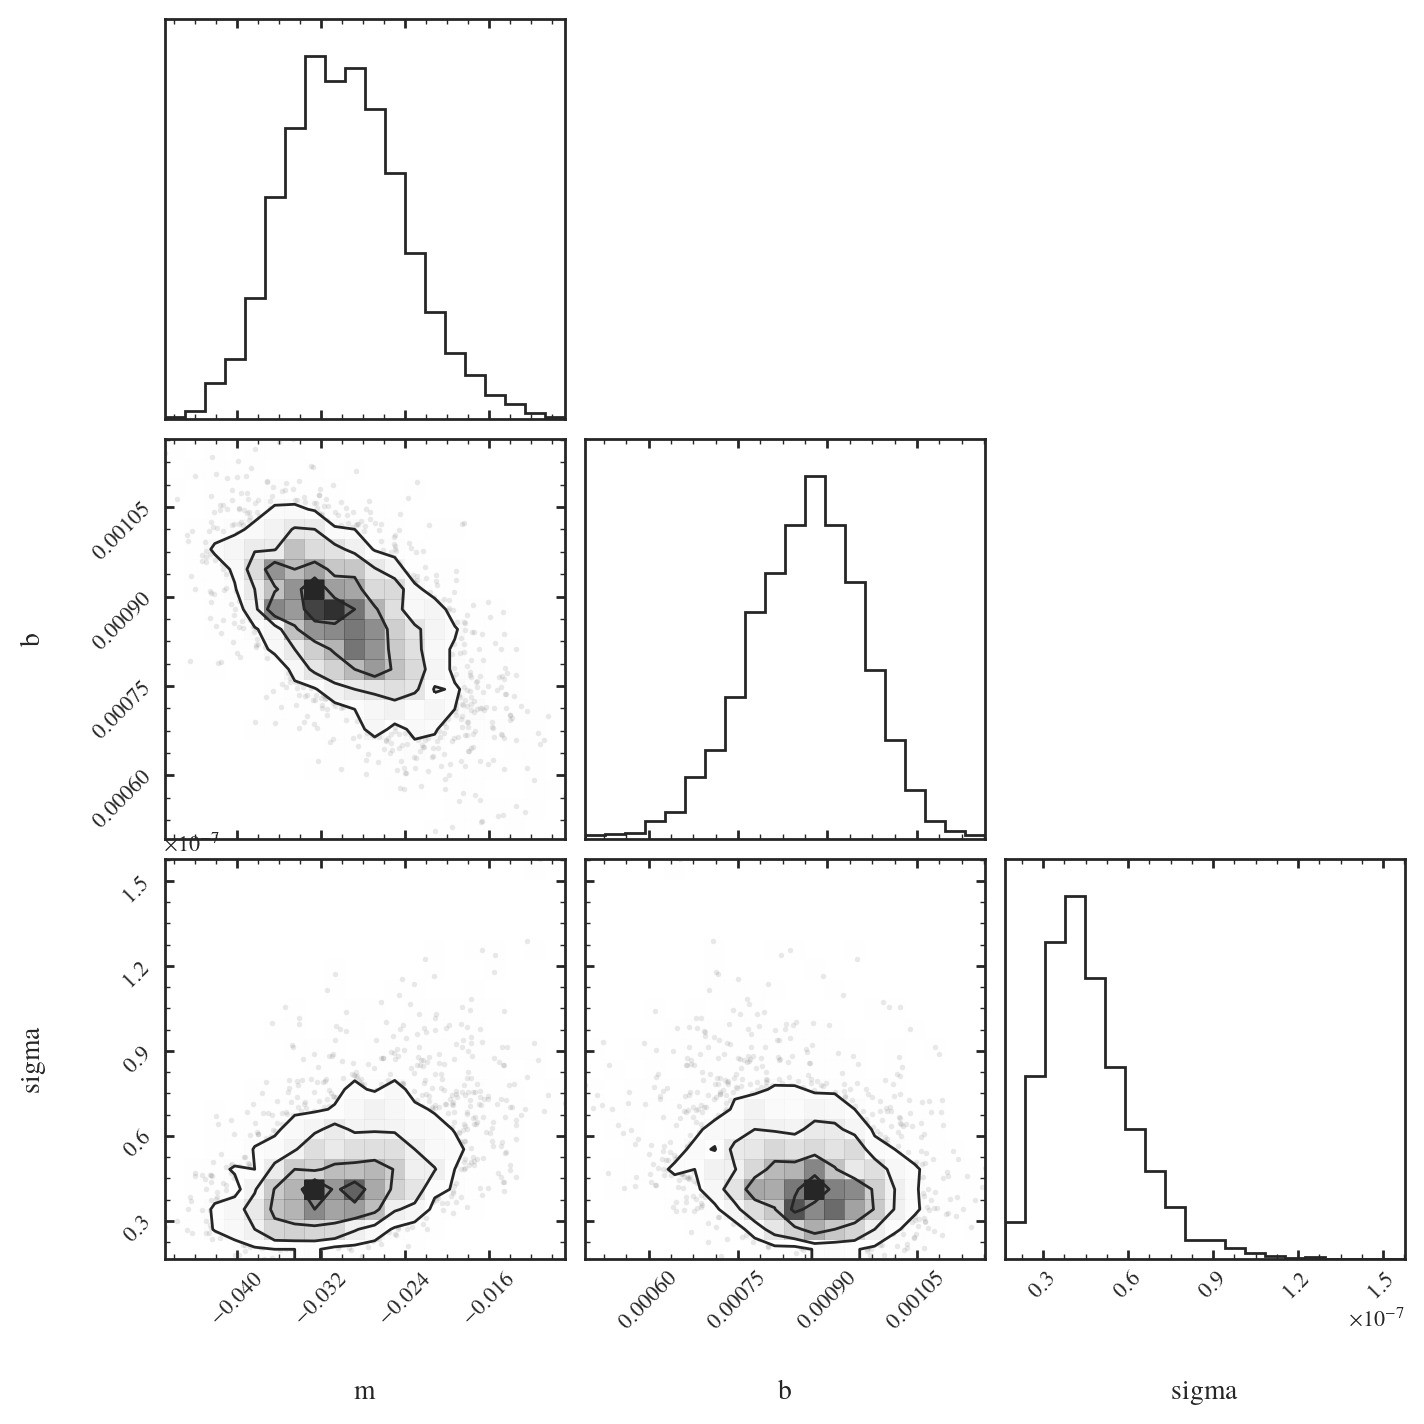

In [245]:

model = LogLinearModel()
p0 = model.p0(1)
ndim, nwalkers = len(p0), 50
p0 = p0 *  (1 + 1e-4 * np.random.randn(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(mh1, y_c_agb1, model))
sampler.run_mcmc(p0, 1000, progress=True);
samples = sampler.get_chain(discard=100, thin=15, flat=True)
corner(samples, labels=["m", "b", "sigma"]);

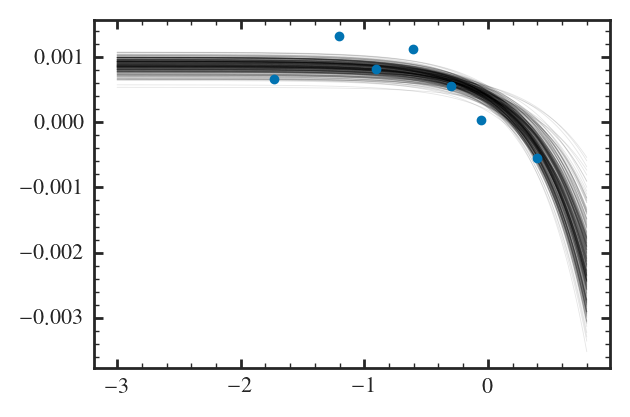

In [246]:

for i in range(0, len(samples), 10):
    theta = samples[i, :]
    x = np.linspace(-3, 0.8, 1000)
    y = model(x, theta)
    plt.plot(x, y, lw=0.3, color="k", alpha=0.1)
    
plt.scatter(mh1, y_c_agb1, zorder=3)


# K16

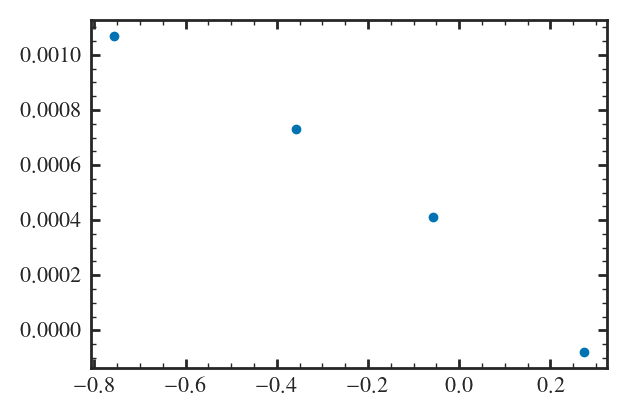

In [231]:
study = "karakas16"
y1, m1, z1 = vice.yields.agb.grid("c", study=study)
mh1 = Z_to_MH(z1)
vice.yields.agb.settings["c"] = vice.yields.agb.interpolator("c", study=study)
y_c_agb1 = np.array([surp.calc_y(z) for z in z1])

plt.scatter(mh1, y_c_agb1)

  5%|▌         | 52/1000 [00:00<00:03, 262.75it/s]/tmp/slurmtmp.26960816/ipykernel_214441/4271747773.py:5: RuntimeWarning: invalid value encountered in log
  return np.where(x >= 0, normal(np.log(x), np.log(mu), sigma), 0)
/tmp/slurmtmp.26960816/ipykernel_214441/2739109048.py:14: RuntimeWarning: divide by zero encountered in log
  p += np.log(log_normal(sigma, 1e-8, 0.5))
/tmp/slurmtmp.26960816/ipykernel_214441/4247209102.py:4: RuntimeWarning: invalid value encountered in log
  return -0.5 * np.sum((y - pred) ** 2 / sigma2 + np.log(2 * np.pi * sigma2))
100%|██████████| 1000/1000 [00:02<00:00, 338.41it/s]


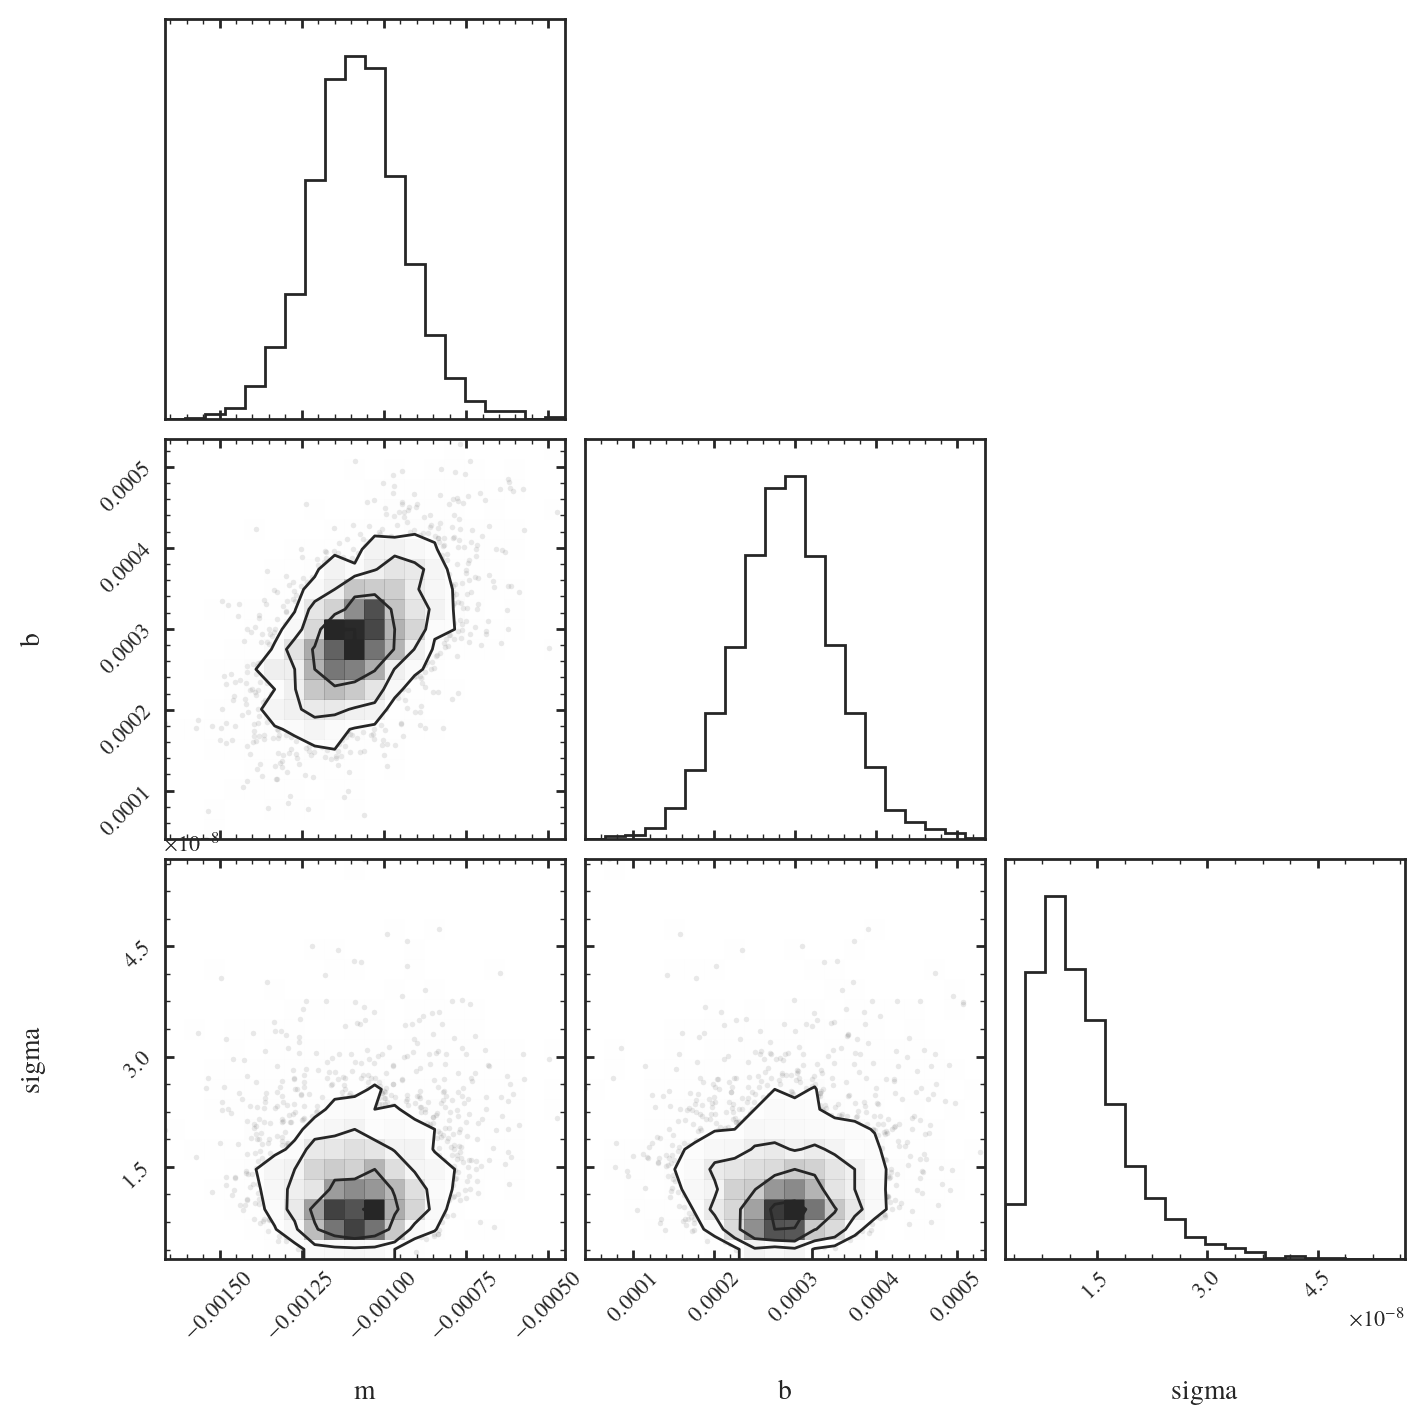

In [237]:

model = LinearModel()
p0 = model.p0(1)
ndim, nwalkers = len(p0), 50
p0 = p0 *  (1 + 1e-4 * np.random.randn(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(mh1, y_c_agb1, model))
sampler.run_mcmc(p0, 1000, progress=True);
samples = sampler.get_chain(discard=100, thin=15, flat=True)
corner(samples, labels=["m", "b", "sigma"]);

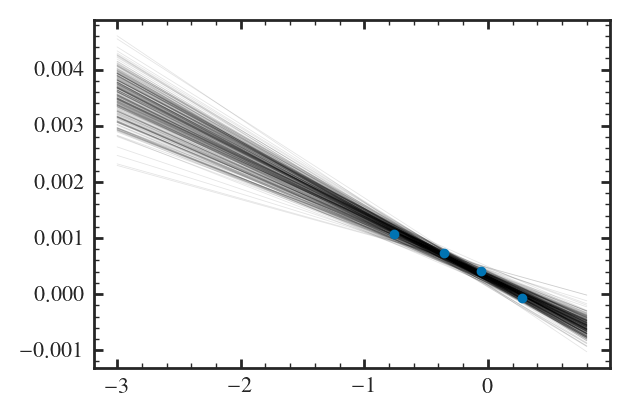

In [238]:

for i in range(0, len(samples), 10):
    theta = samples[i, :]
    x = np.linspace(-3, 0.8, 1000)
    y = model(x, theta)
    plt.plot(x, y, lw=0.3, color="k", alpha=0.1)
    
plt.scatter(mh1, y_c_agb1, zorder=3)


# P16

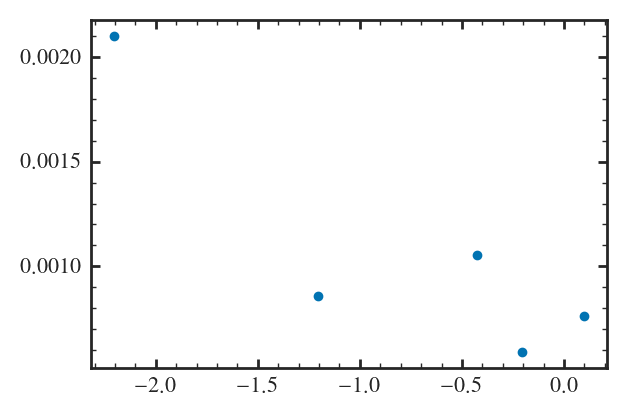

In [239]:
study = "pignatari16"
y1, m1, z1 = vice.yields.agb.grid("c", study=study)
mh1 = Z_to_MH(z1)
vice.yields.agb.settings["c"] = vice.yields.agb.interpolator("c", study=study)
y_c_agb1 = np.array([surp.calc_y(z) for z in z1])

plt.scatter(mh1, y_c_agb1)

  2%|▏         | 21/1000 [00:00<00:04, 209.94it/s]/tmp/slurmtmp.26960816/ipykernel_214441/4271747773.py:5: RuntimeWarning: invalid value encountered in log
  return np.where(x >= 0, normal(np.log(x), np.log(mu), sigma), 0)
/tmp/slurmtmp.26960816/ipykernel_214441/2739109048.py:14: RuntimeWarning: divide by zero encountered in log
  p += np.log(log_normal(sigma, 1e-8, 0.5))
/tmp/slurmtmp.26960816/ipykernel_214441/4247209102.py:4: RuntimeWarning: invalid value encountered in log
  return -0.5 * np.sum((y - pred) ** 2 / sigma2 + np.log(2 * np.pi * sigma2))
100%|██████████| 1000/1000 [00:03<00:00, 304.30it/s]


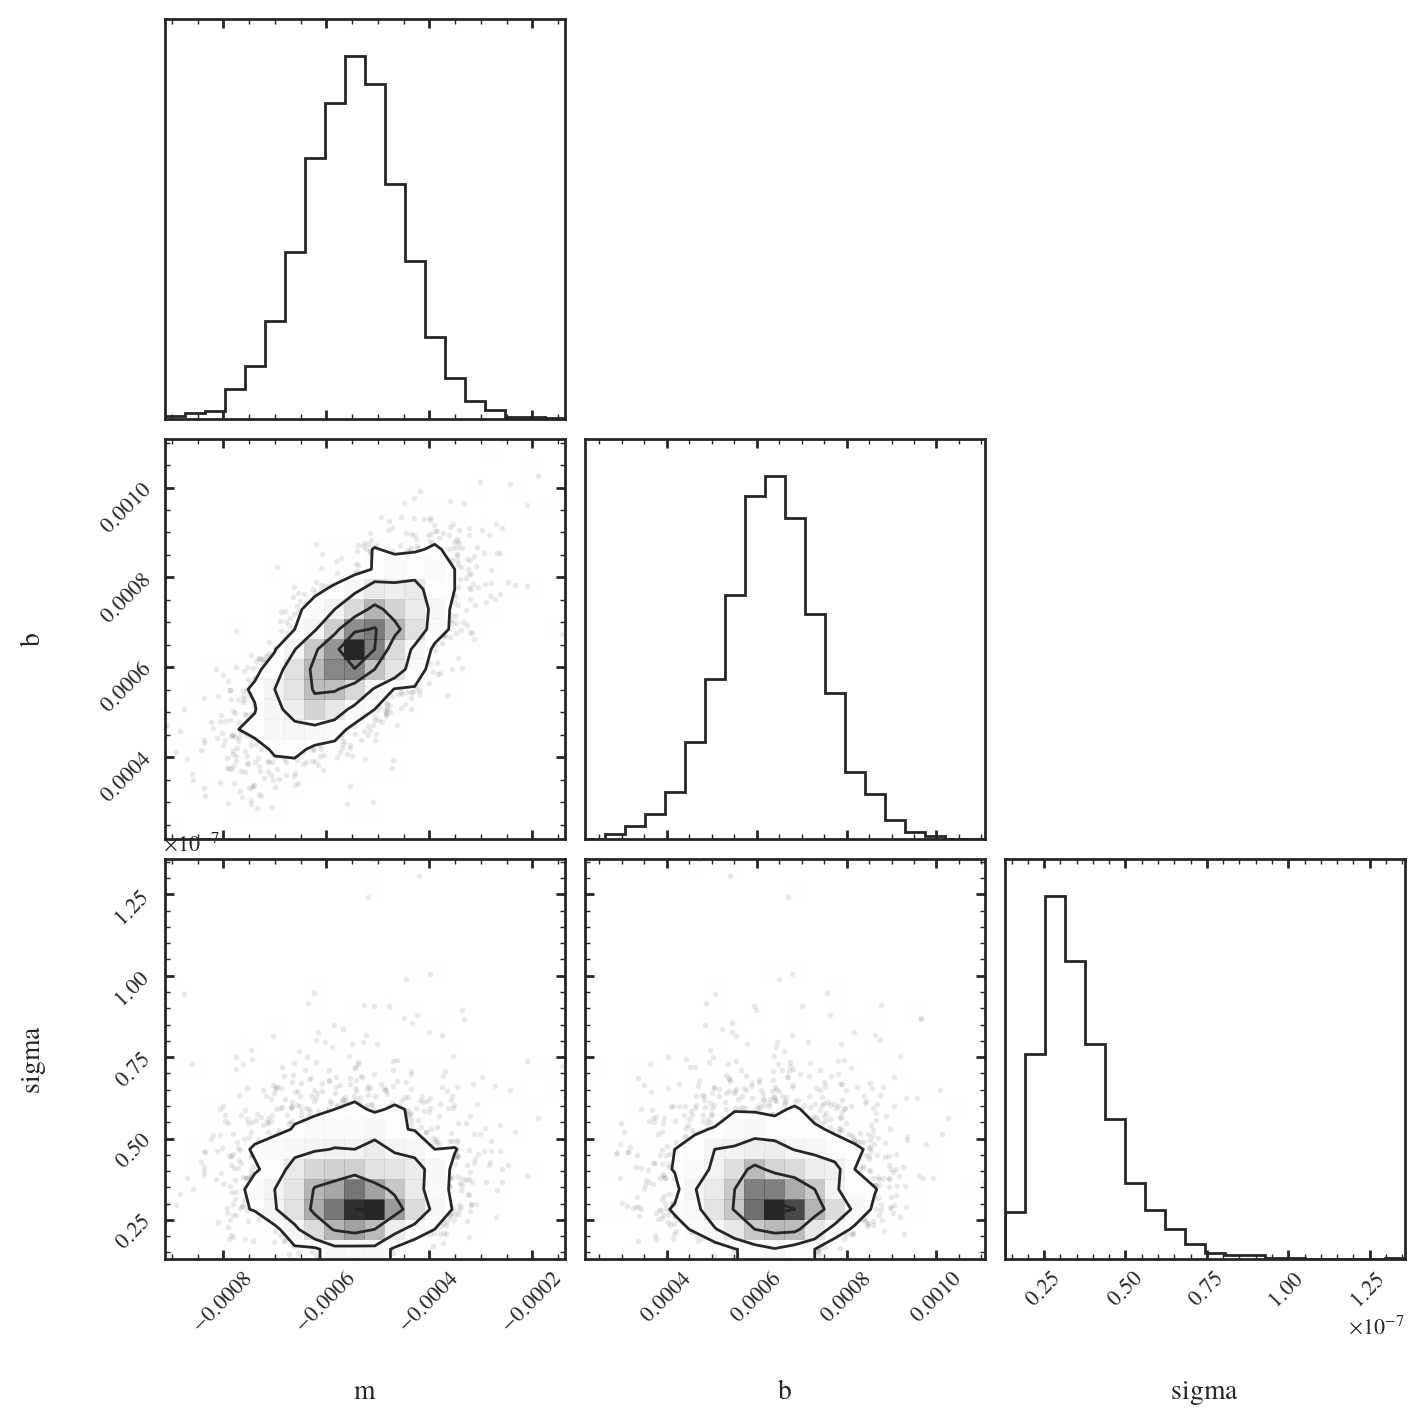

In [240]:

model = LinearModel()
p0 = model.p0(1)
ndim, nwalkers = len(p0), 50
p0 = p0 *  (1 + 1e-4 * np.random.randn(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(mh1, y_c_agb1, model))
sampler.run_mcmc(p0, 1000, progress=True);
samples = sampler.get_chain(discard=100, thin=15, flat=True)
corner(samples, labels=["m", "b", "sigma"]);

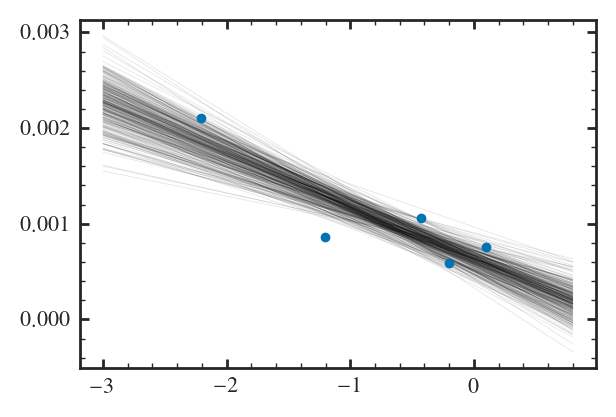

In [241]:

for i in range(0, len(samples), 10):
    theta = samples[i, :]
    x = np.linspace(-3, 0.8, 1000)
    y = model(x, theta)
    plt.plot(x, y, lw=0.3, color="k", alpha=0.1)
    
plt.scatter(mh1, y_c_agb1, zorder=3)
